In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/My\ Drive/masters

In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN, evaluate_fnn
from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_results, save_metrics, compare_all_models, get_models_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from utils.utils import pshape, get_data_sub_paths, by_ref
from trainers.generic_trainer import train_model
from models.kangkang_fnn_models import train_epoch_for_fnn

from utils.metrics import best_threshold, get_y_pred, get_y_pred_by_thresholds, best_thresholds
from time import time
from torch.optim import lr_scheduler


In [2]:
data_sub_paths = get_data_sub_paths()
print(np.sort(data_sub_paths))

['T1H-X3400M-Y3520M_2014-01-01_2016-01-01_#7cd'
 'T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97'
 'T24H-X425M-Y440M_2012-01-01_2019-01-01_#827'
 'T24H-X850M-Y880M_2012-01-01_2019-01-01_#826']


In [16]:
data_sub_paths = by_ref("c97")
data_sub_paths

['T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97']

In [17]:
from pprint import pprint
conf = BaseConf()

In [18]:
log.getLogger().setLevel("INFO")

2020-10-22T21:33:00 | root | INFO | 
                       ROC AUC  Avg. Precision  Precision    Recall  F1 Score  \
Model Name                                                                      
SimpleKangFNN_latest  0.822939        0.454138   0.401918  0.546641  0.463239   
KangFNN_latest        0.820764        0.453561   0.421304  0.518591  0.464912   
Ind-Hawkes Model      0.818610        0.449415   0.403947  0.538010  0.461438   
Historic Average      0.818954        0.448149   0.417658  0.526064  0.465635   
Global Average        0.818777        0.443838   0.418814  0.504778  0.457796   
Previous Time Step    0.616013        0.216407   0.322097  0.321677  0.321887   

                      Accuracy       MCC       PAI      RMSE       MAE  
Model Name                                                              
SimpleKangFNN_latest  0.843522  0.380200  3.725403  0.590234  0.398170  
KangFNN_latest        0.852546  0.383226  3.948074  0.545546  0.331726  
Ind-Hawkes Model      

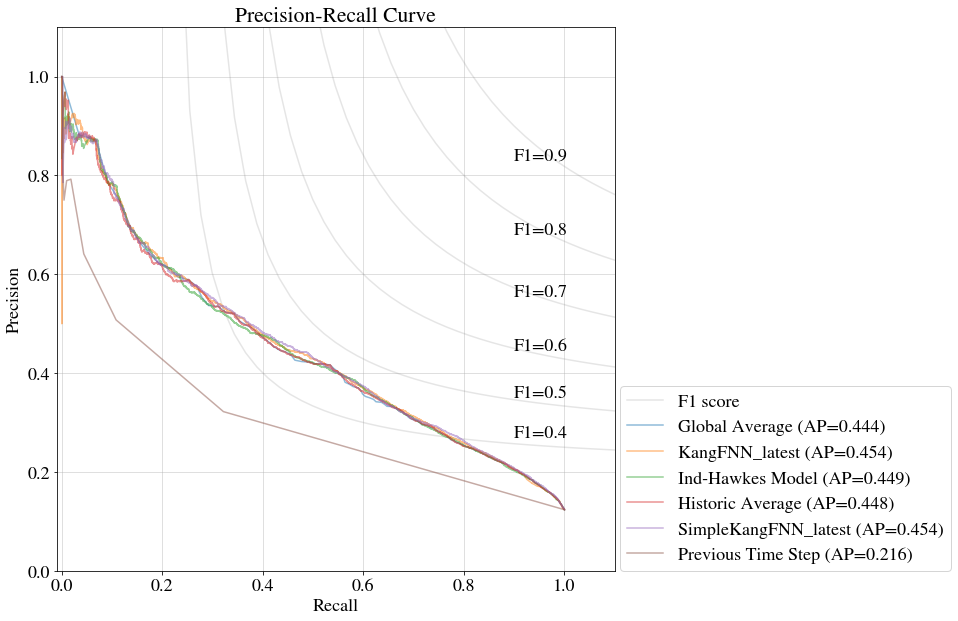

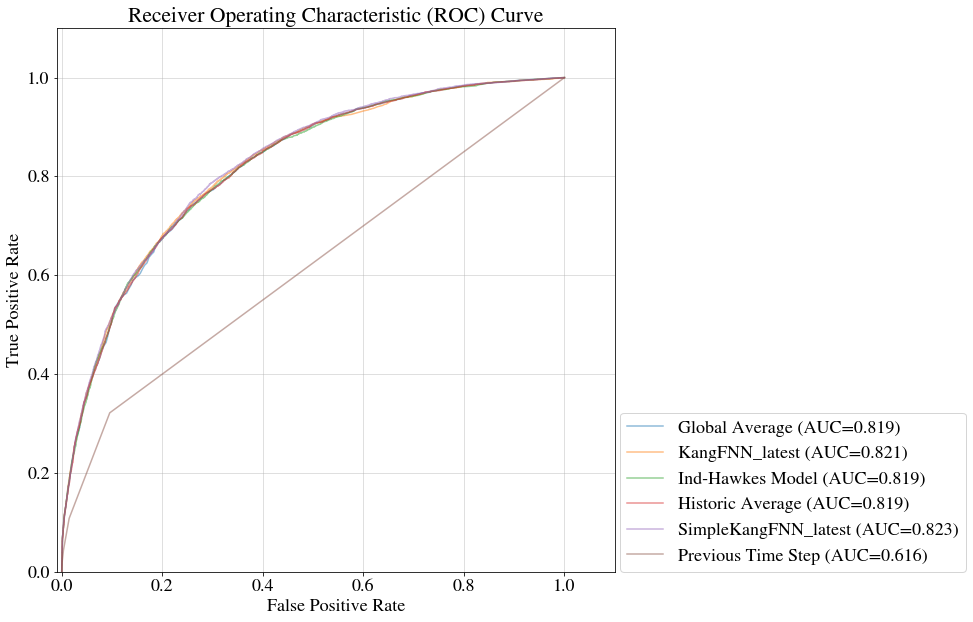

AttributeError: 'ModelMetrics' object has no attribute 'det_curve'

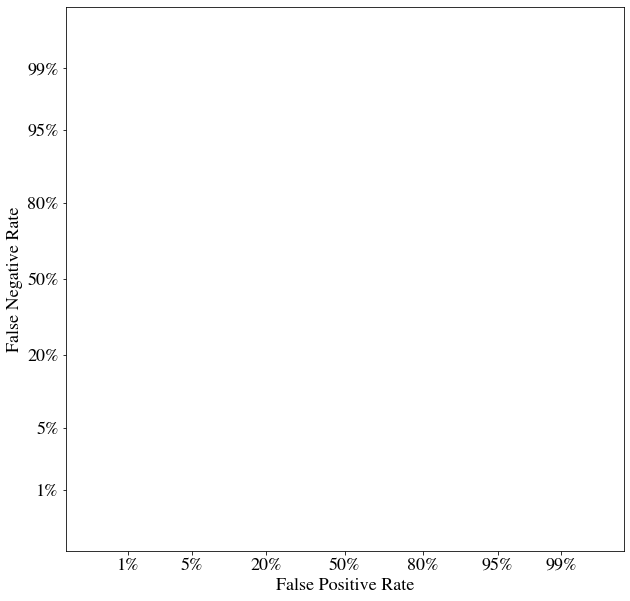

In [19]:
# T24H-X850M-Y880M_2012-01-01_2019-01-01

data_sub_path = data_sub_paths[0]

# manually set
conf = BaseConf()
conf.seed = int(time()) # 3
conf.model_name = "KangFNN" # "SimpleKangFNN" # "KangFNN"  # needs to be created
conf.data_path = f"./data/processed/{data_sub_path}/"

compare_all_models(data_path=conf.data_path)

if not os.path.exists(conf.data_path):
    raise Exception(f"Directory ({conf.data_path}) needs to exist.")

conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
os.makedirs(conf.data_path, exist_ok=True)
os.makedirs(conf.model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=conf.model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")


info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = False # torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

In [20]:
# SET THE HYPER PARAMETERS
conf.resume = False
conf.early_stopping = True
conf.patience = 50
conf.min_epochs = 1
conf.max_epochs = 100 # conf.min_epochs + conf.patience + 100
conf.dropout = 0 # 0.5 # should be between 0.5 and 0.8 for input dropout rates
conf.weight_decay = 0  # [0, 1e-8, 1e-6, 1e-4, 1e-2]
conf.checkpoint = "latest" #"latest" # ["best_val", "best_trn", "best_trn_val"]
conf.lr = 1e-2
conf.shaper_top_k = -1
conf.batch_size = 256
conf.use_classification = True
conf.train_set_first = True


MOCK = False

if MOCK:
    # MOCK THE DATA
    vector_size= [5,5,5]#[37,65,512]    
    class_split=0.5
    train_loader = MockLoader(vector_size, conf.batch_size, n_samples=1000, class_split=class_split)
    validation_loader = MockLoader(vector_size, conf.batch_size, n_samples=200, class_split=class_split)
    test_loader = MockLoader(vector_size, conf.batch_size, n_samples=300, class_split=class_split)
    loaders = MockLoaders(train_loader,validation_loader,test_loader)
else:
    # CRIME DATA - sub-sample classes to even out class label ratios
    conf.sub_sample_test_set = 0
    conf.sub_sample_train_set = 10 # 1 # 2 # 5 # 10
    conf.sub_sample_validation_set = 10 # 1 # 2 # 5 # 10

    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)

conf.freqstr = data_group.t_range.freqstr    

# SET LOSS FUNCTION
# size averaged - so more epochs or larger lr for smaller batches
loss_function = nn.CrossEntropyLoss()
# if conf.use_classification:
#     loss_function = nn.CrossEntropyLoss()
#     log.info("loss function: cross entropy loss")
# else:
#     loss_function = nn.MSELoss()
#     log.info("loss function: mean square error loss")

# SETUP MODEL
train_set = loaders.train_loader.dataset
indices, spc_feats, tmp_feats, env_feats, target, labels = train_set[train_set.min_index]
spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]


if conf.model_name == "SimpleKangFNN":
    model_arch = {
        "h_size0": 10,
        "h_size1": 10,
        "h_size2": 10,
    }
    model = SimpleKangFNN(spc_size=spc_size,
                          tmp_size=tmp_size,
                          env_size=env_size,
                          dropout_p=conf.dropout,
                          model_arch=model_arch)
else:
#     model_arch = {
#         "scp_net_h0": 64,
#         "scp_net_h1": 32,
#         "tmp_net_h0": 64,
#         "tmp_net_h1": 32,
#         "env_net_h0": 64,
#         "env_net_h1": 32,
#         "final_net_h1": 64,
#     }
    
    model_arch = None # if none will use default architechture
    
    model = KangFeedForwardNetwork(spc_size=spc_size,
                                   tmp_size=tmp_size,
                                   env_size=env_size,
                                   dropout_p=conf.dropout,
                                   model_arch=model_arch)

    
pprint(conf)
model.to(conf.device)

# SETUP OPTIMISER
parameters = model.parameters()

# important note: using weight decay (l2 penalty) can prohibit long term memory in LSTM networks
# - use gradient clipping instead
optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay, amsgrad=False)
# optimiser = optim.SGD(params=parameters, lr=conf.lr)
scheduler = None
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optimiser, T_max=10)#conf.max_epochs//5)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.1, patience=10,
#                                            threshold=0.0001, threshold_mode='rel', cooldown=0,
#                                            min_lr=0, eps=1e-08, verbose=False)


##### RESUME LOGIC
if conf.resume:  # todo check if the files actually exist
    try:
        # resume from previous check point or resume from best validaton score checkpoint
        # load model state
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                      map_location=conf.device.type)
        model.load_state_dict(model_state_dict)
        
        # load optimiser state
        optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                          map_location=conf.device.type)
        optimiser.load_state_dict(optimiser_state_dict) 

        # new optimiser hyper-parameters
        optimiser.param_groups[0]['lr'] = conf.lr
        optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

        # new model hyper-parameters
        model.dropout.p = conf.dropout # note that drop out is not part of the saved state dict

    except Exception as e:
        log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

2020-10-22T21:33:01 | root | INFO | Initialising Flat Data Group
2020-10-22T21:33:01 | root | INFO | loading crimes grids WITHOUT crime types
2020-10-22T21:33:01 | root | INFO | 	t_range: (2558,) 2012-01-01 00:00:00 -> 2019-01-01 00:00:00
2020-10-22T21:33:01 | root | INFO | 	target_len:	2191	(100.000%)
2020-10-22T21:33:01 | root | INFO | 	trn_val_size:	1831	(83.569%)
2020-10-22T21:33:01 | root | INFO | 	trn_size:	1374	(62.711%)
2020-10-22T21:33:01 | root | INFO | 	val_size:	457	(20.858%)
2020-10-22T21:33:01 | root | INFO | 	tst_size:	360 	(16.431%)
fitted historic average: step (1) and max_steps (-1)
{'batch_size': 256,
 'checkpoint': 'latest',
 'data_path': './data/processed/T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97/',
 'device': None,
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.01,
 'max_epochs': 100,
 'min_epochs': 1,
 'model_name': 'KangFNN',
 'model_path': '',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_s

2020-10-22T21:33:01 | root | INFO | 
 ====================== Training KangFNN ====================== 

2020-10-22T21:33:01 | root | INFO | 
 ====================== Config Values ====================== 
{'batch_size': 256,
 'checkpoint': 'latest',
 'data_path': './data/processed/T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97/',
 'device': None,
 'dropout': 0,
 'early_stopping': True,
 'flatten_grid': True,
 'freqstr': '24H',
 'lr': 0.01,
 'max_epochs': 100,
 'min_epochs': 1,
 'model_name': 'KangFNN',
 'model_path': '',
 'n_channels': 3,
 'n_layers': 3,
 'n_steps_c': 3,
 'n_steps_p': 3,
 'n_steps_q': 3,
 'num_workers': 8,
 'pad_width': 0,
 'patience': 50,
 'resume': False,
 'seed': 1603395180,
 'seq_len': 1,
 'shaper_threshold': 10,
 'shaper_top_k': -1,
 'shuffle': True,
 'sub_sample_test_set': 0,
 'sub_sample_train_set': 10,
 'sub_sample_validation_set': 10,
 'test_set_size_days': 360,
 'timer': <utils.utils.Timer object at 0x7f43bc48c190>,
 'tolerance': 1e-08,
 'train_set_first': True,
 '

2020-10-22T21:35:06 | root | INFO | 	Loss (Trn): 		0.53322276
2020-10-22T21:35:06 | root | INFO | 	Loss (Best Trn): 	0.53270011
2020-10-22T21:35:06 | root | INFO | 	Loss (Val): 		0.52216857
2020-10-22T21:35:06 | root | INFO | 	Loss (Best Val): 	0.51952085
2020-10-22T21:35:06 | root | INFO | 	Loss (Trn Val): 	1.05539133
2020-10-22T21:35:06 | root | INFO | 	Loss (Best Trn Val): 	1.05222097
2020-10-22T21:35:06 | root | INFO | 	Loss (Trn Val Dif): 	0.01105419

2020-10-22T21:35:06 | root | INFO | Epoch: 0015/0100
2020-10-22T21:35:15 | root | INFO | 	Loss (Trn): 		0.53247201
2020-10-22T21:35:15 | root | INFO | 	Loss (Best Trn): 	0.53247201
2020-10-22T21:35:15 | root | INFO | 	Loss (Val): 		0.53670125
2020-10-22T21:35:15 | root | INFO | 	Loss (Best Val): 	0.51952085
2020-10-22T21:35:15 | root | INFO | 	Loss (Trn Val): 	1.06917326
2020-10-22T21:35:15 | root | INFO | 	Loss (Best Trn Val): 	1.05222097
2020-10-22T21:35:15 | root | INFO | 	Loss (Trn Val Dif): 	0.00422925

2020-10-22T21:35:15 | roo

2020-10-22T21:37:27 | root | INFO | 	Loss (Trn): 		0.52465858
2020-10-22T21:37:27 | root | INFO | 	Loss (Best Trn): 	0.52410165
2020-10-22T21:37:27 | root | INFO | 	Loss (Val): 		0.52906965
2020-10-22T21:37:27 | root | INFO | 	Loss (Best Val): 	0.51952085
2020-10-22T21:37:27 | root | INFO | 	Loss (Trn Val): 	1.05372823
2020-10-22T21:37:27 | root | INFO | 	Loss (Best Trn Val): 	1.04937463
2020-10-22T21:37:27 | root | INFO | 	Loss (Trn Val Dif): 	0.00441107

2020-10-22T21:37:27 | root | INFO | Epoch: 0031/0100
2020-10-22T21:37:36 | root | INFO | 	Loss (Trn): 		0.52405983
2020-10-22T21:37:36 | root | INFO | 	Loss (Best Trn): 	0.52405983
2020-10-22T21:37:36 | root | INFO | 	Loss (Val): 		0.52958667
2020-10-22T21:37:36 | root | INFO | 	Loss (Best Val): 	0.51952085
2020-10-22T21:37:36 | root | INFO | 	Loss (Trn Val): 	1.05364649
2020-10-22T21:37:36 | root | INFO | 	Loss (Best Trn Val): 	1.04937463
2020-10-22T21:37:36 | root | INFO | 	Loss (Trn Val Dif): 	0.00552684

2020-10-22T21:37:36 | roo

2020-10-22T21:39:51 | root | INFO | 	Loss (Trn): 		0.51828414
2020-10-22T21:39:51 | root | INFO | 	Loss (Best Trn): 	0.51748578
2020-10-22T21:39:51 | root | INFO | 	Loss (Val): 		0.53060623
2020-10-22T21:39:51 | root | INFO | 	Loss (Best Val): 	0.51952085
2020-10-22T21:39:51 | root | INFO | 	Loss (Trn Val): 	1.04889037
2020-10-22T21:39:51 | root | INFO | 	Loss (Best Trn Val): 	1.04749676
2020-10-22T21:39:51 | root | INFO | 	Loss (Trn Val Dif): 	0.01232209

2020-10-22T21:39:51 | root | INFO | Epoch: 0047/0100
2020-10-22T21:40:01 | root | INFO | 	Loss (Trn): 		0.51738289
2020-10-22T21:40:01 | root | INFO | 	Loss (Best Trn): 	0.51738289
2020-10-22T21:40:01 | root | INFO | 	Loss (Val): 		0.53053318
2020-10-22T21:40:01 | root | INFO | 	Loss (Best Val): 	0.51952085
2020-10-22T21:40:01 | root | INFO | 	Loss (Trn Val): 	1.04791607
2020-10-22T21:40:01 | root | INFO | 	Loss (Best Trn Val): 	1.04749676
2020-10-22T21:40:01 | root | INFO | 	Loss (Trn Val Dif): 	0.01315029

2020-10-22T21:40:01 | roo

2020-10-22T21:42:16 | root | INFO | 	Loss (Trn): 		0.51334703
2020-10-22T21:42:16 | root | INFO | 	Loss (Best Trn): 	0.51334703
2020-10-22T21:42:16 | root | INFO | 	Loss (Val): 		0.53587142
2020-10-22T21:42:16 | root | INFO | 	Loss (Best Val): 	0.51952085
2020-10-22T21:42:16 | root | INFO | 	Loss (Trn Val): 	1.04921845
2020-10-22T21:42:16 | root | INFO | 	Loss (Best Trn Val): 	1.04597542
2020-10-22T21:42:16 | root | INFO | 	Loss (Trn Val Dif): 	0.02252439

2020-10-22T21:42:16 | root | INFO | Epoch: 0063/0100
2020-10-22T21:42:25 | root | INFO | 	Loss (Trn): 		0.51364933
2020-10-22T21:42:25 | root | INFO | 	Loss (Best Trn): 	0.51334703
2020-10-22T21:42:25 | root | INFO | 	Loss (Val): 		0.53511134
2020-10-22T21:42:25 | root | INFO | 	Loss (Best Val): 	0.51952085
2020-10-22T21:42:25 | root | INFO | 	Loss (Trn Val): 	1.04876067
2020-10-22T21:42:25 | root | INFO | 	Loss (Best Trn Val): 	1.04597542
2020-10-22T21:42:25 | root | INFO | 	Loss (Trn Val Dif): 	0.02146201

2020-10-22T21:42:25 | roo

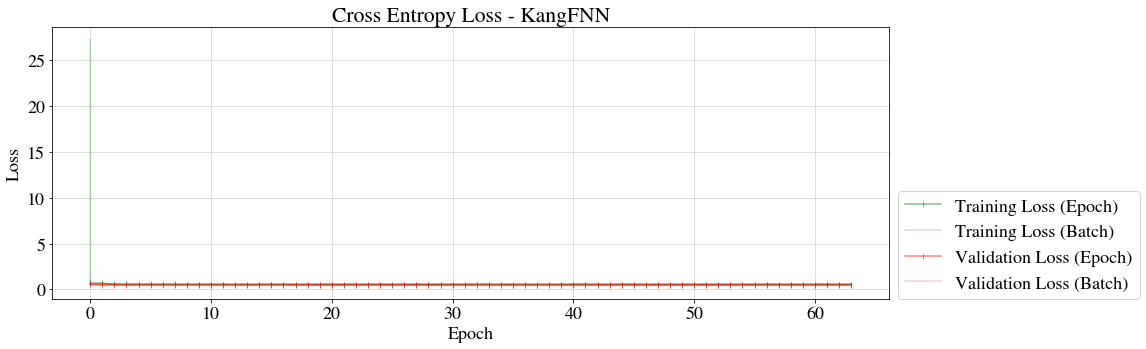

In [21]:
trn_epoch_losses, val_epoch_losses, stopped_early = train_model(
    model=model,
    optimiser=optimiser,
    loaders=loaders,
    train_epoch_fn=train_epoch_for_fnn,
    loss_fn=loss_function,
    conf=conf,
    scheduler=scheduler,
)    

print(f"stopped_early: {stopped_early}") # use the current epoch instead
# if stopped_early -> continue with best_model - new hyper-parameters -> no n 

In [22]:
from utils.interactive import plot_interactive_epoch_losses
plot_interactive_epoch_losses(trn_epoch_losses, val_epoch_losses)

# Evaluation

In [10]:
# Load latest or best validation model
# conf.checkpoint = "latest"
conf.checkpoint = "best_val"
# conf.checkpoint = "best_trn"
# conf.checkpoint = "best_trn_val"

conf.model_name = f"{model.name}_{conf.checkpoint}"

log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

# resume from previous check point or resume from best validaton score checkpoint
# load model state
model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                map_location=conf.device.type)
model.load_state_dict(model_state_dict)


2020-10-21T22:02:26 | root | INFO | Loading model from checkpoint (best_val) for evaluation


<All keys matched successfully>

In [11]:
conf.sub_sample_test_set = 0
conf.sub_sample_train_set = 0
conf.sub_sample_validation_set = 0

loaders = FlatDataLoaders(data_group=data_group, conf=conf)

In [12]:
# todo set the train_loader to eval so that it does not subsample
trn_y_count, trn_y_class, trn_y_score, trn_t_range = evaluate_fnn(model=model,
                                                        batch_loader=loaders.train_loader,
                                                        conf=conf)

tst_y_count, tst_y_class, tst_y_score, tst_t_range = evaluate_fnn(model=model,
                                                        batch_loader=loaders.test_loader,
                                                        conf=conf)

thresh = best_threshold(y_class=trn_y_class,
                        y_score=trn_y_score)
tst_y_pred = get_y_pred(thresh=thresh,
                        y_score=tst_y_score)    

tst_y_count = loaders.data_group.to_counts(tst_y_count)     
        
save_metrics(y_count=tst_y_count,
             y_pred=tst_y_pred,
             y_score=tst_y_score,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)   

# save_results(y_true=tst_y_true,
#              y_pred=tst_y_pred,
#              probas_pred=tst_probas_pred,
#              t_range=tst_t_range,
#              shaper=data_group.shaper,                
#              conf=conf)

2020-10-21T22:02:42 | root | INFO | f1_score: 0.8005873462028001 at index 49132, new threshold 0.3323008418083191
2020-10-21T22:02:43 | root | INFO | 
            MODEL METRICS (Over All Samples)
            Class Balance (Crime:No-Crime) - 1:0.713
                Model Name: KangFNN_best_val
                    ROC AUC:            0.80344                
                    Average Precision:  0.84481
                    Precision:          0.71122
                    Recall:             0.89918
                    Accuracy:           0.72799
                    MCC:                0.43391
                    PAI:                1.27779
                    MAE:                1.08324
                    RMSE:               1.84505      
            


2020-10-21T22:02:43 | root | INFO | 
                     ROC AUC  Avg. Precision  Precision    Recall  F1 Score  \
Model Name                                                                    
KangFNN_best_val    0.803441        0.844808   0.711218  0.899182  0.794231   
Historic Average    0.804429        0.842279   0.715973  0.891210  0.794038   
Global Average      0.803814        0.840450   0.689207  0.931217  0.792140   
Ind-Hawkes Model    0.801730        0.839984   0.702404  0.911955  0.793579   
ST-RESNET-Extra     0.792073        0.832426   0.707985  0.892870  0.789751   
Previous Time Step  0.691651        0.732345   0.580213  1.000000  0.734347   

                    Accuracy       MCC       PAI      RMSE       MAE  
Model Name                                                            
KangFNN_best_val    0.727988  0.433907  1.277788  1.845052  1.083236  
Historic Average    0.731748  0.443558  1.299148  2.084448  1.227858  
Global Average      0.716445  0.420691  1.2271

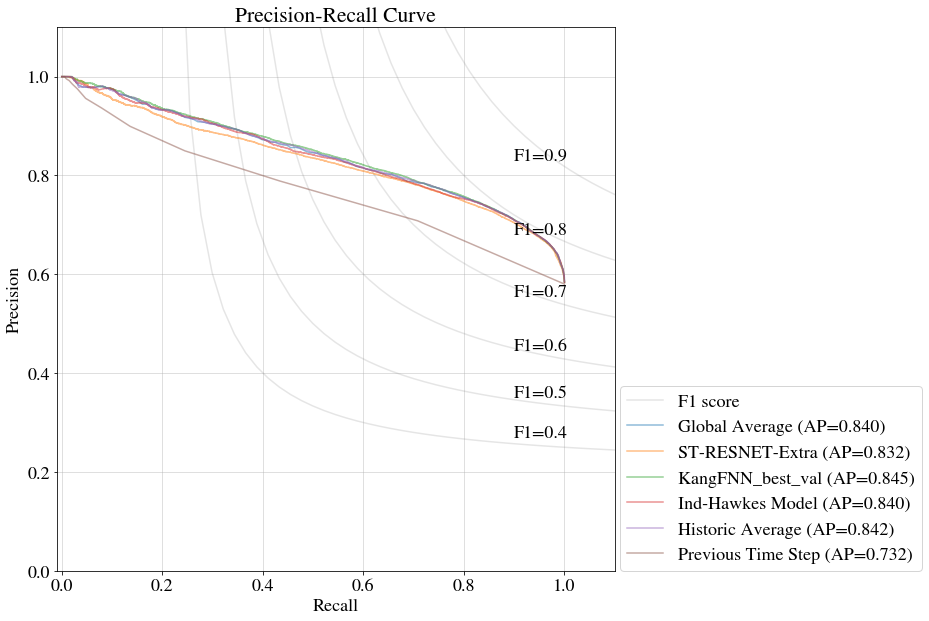

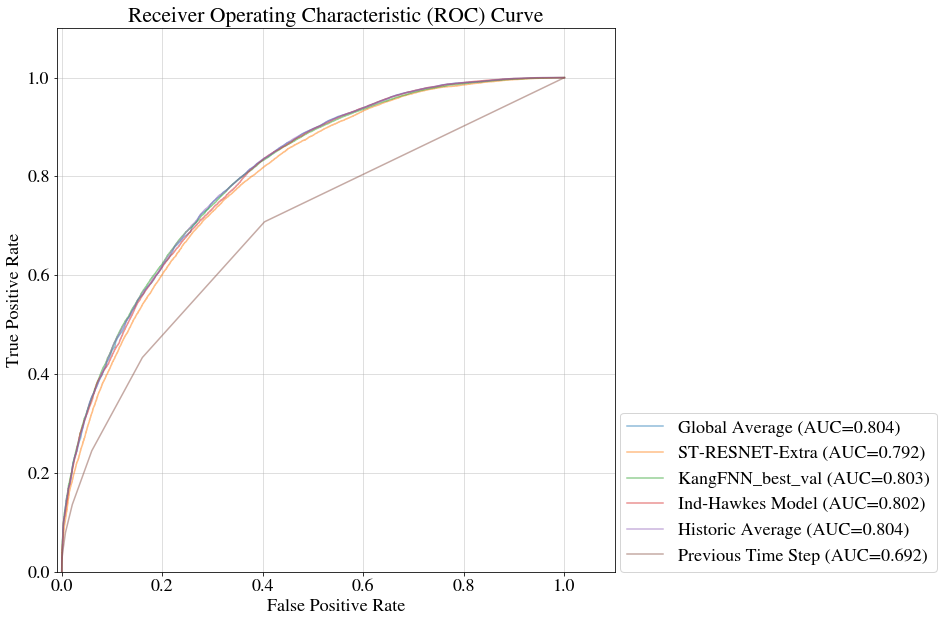

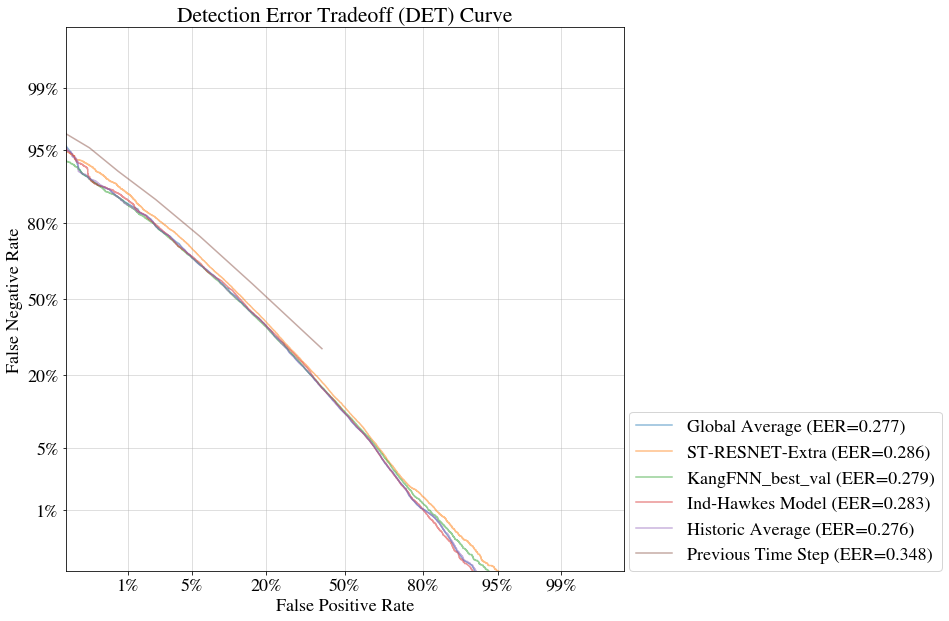

,ROC AUC,Avg. Precision,Precision,Recall,F1 Score,Accuracy,MCC,PAI,RMSE,MAE
Model Name,,,,,,,,,,
KangFNN_best_val,0.803441,0.844808,0.711218,0.899182,0.794231,0.727988,0.433907,1.277788,1.845052,1.083236
Historic Average,0.804429,0.842279,0.715973,0.891210,0.794038,0.731748,0.443558,1.299148,2.084448,1.227858
Global Average,0.803814,0.840450,0.689207,0.931217,0.792140,0.716445,0.420691,1.227193,2.084372,1.227779
Ind-Hawkes Model,0.801730,0.839984,0.702404,0.911955,0.793579,0.724733,0.432655,1.261930,1.845232,1.082454
ST-RESNET-Extra,0.792073,0.832426,0.707985,0.892870,0.789751,0.722452,0.420897,1.274694,2.062293,1.222439
Previous Time Step,0.691651,0.732345,0.580213,1.000000,0.734347,0.580213,0.000000,1.000000,2.082301,1.225185


In [13]:
compare_all_models(data_path=conf.data_path)

In [16]:
# from utils.interactive import plot_interactive_roc, plot_interactive_pr
# plot_interactive_pr(conf.data_path,beta=1).show()
# plot_interactive_roc(conf.data_path).show()

### View Training Predictions

In [15]:
trn_y_count, trn_y_class, trn_y_score, trn_t_range = evaluate_fnn(model=model,
                                                                  batch_loader=loaders.train_loader,
                                                                  conf=conf)

trn_y_count = data_group.shaper.unsqueeze(trn_y_count)
trn_y_class = data_group.shaper.unsqueeze(trn_y_class)
trn_y_score = data_group.shaper.unsqueeze(trn_y_score)

from utils.interactive import InteractiveHeatmaps

InteractiveHeatmaps(
    date_range=trn_t_range, 
    col_wrap=1,
    Counts=trn_y_count[:,0], 
    Hotspots=trn_y_class[:,0],
    Probabilities=trn_y_score[:,0],
).app

### View testing predictions

In [33]:
from utils.interactive import InteractiveHeatmaps

tst_y_count, tst_y_class, tst_y_score, tst_t_range = evaluate_fnn(model=model,
                                                                  batch_loader=loaders.test_loader,
                                                                  conf=conf)

tst_y_count = data_group.shaper.unsqueeze(tst_y_count)
tst_y_class = data_group.shaper.unsqueeze(tst_y_class)
tst_y_score = data_group.shaper.unsqueeze(tst_y_score)

from utils.interactive import InteractiveHeatmaps

InteractiveHeatmaps(
    date_range=tst_t_range, 
    col_wrap=3,
    Counts=tst_y_count[:,0], 
    Hotspots=tst_y_class[:,0],
    Probabilities=tst_y_score[:,0],
).app

-----

## All in one code

In [ ]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork, SimpleKangFNN

from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_all_models, get_models_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from utils.utils import pshape
from trainers.generic_trainer import train_model

from models.kangkang_fnn_models import train_epoch_for_fnn

from utils.metrics import best_threshold, get_y_pred

In [ ]:
data_sub_paths = os.listdir("./data/processed/")
data_sub_paths

In [ ]:
data_sub_paths = ['T24H-X255M-Y220M_2012-01-01_2019-01-01_#c97']

In [ ]:

# data_dim_str = "T24H-X255M-Y220M"#"T24H-X850M-Y880M" # "T24H-X85M-Y110M" #"T1H-X1700M-Y1760M"  # needs to exist  
for data_sub_path in data_sub_paths:
    model_name = "Kang FNN"  # needs to be created    
    data_path = f"./data/processed/{data_sub_path}/"
    compare_all_models(data_path=data_path)

    if not os.path.exists(data_path):
        raise Exception(f"Directory ({data_path}) needs to exist.")

    model_path = data_path + f"models/{model_name}/"
    os.makedirs(data_path, exist_ok=True)
    os.makedirs(model_path, exist_ok=True)

    # logging config is set globally thus we only need to call this in this file
    # imported function logs will follow the configuration
    setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")

    timer = Timer()
    # manually set the config
    conf_dict = {
        "seed": 3,
        "use_cuda": True,
        
        "use_crime_types": False,
        
        # data group/data set related
        "val_ratio": 0.1,  # ratio of the total dataset
        "tst_ratio": 0.3,# ratio of the total dataset
        "seq_len": 1,
        "flatten_grid": True,  # if the shaper should be used to squeeze the data
        
        # shaper related 
        "shaper_top_k": -1,  # if less then 0, top_k will not be applied
        "shaper_threshold": 0,

        
        # data loader related
        "sub_sample_train_set": 1,
        "sub_sample_validation_set": 1,
        "sub_sample_validation_set": 0,
        
        # training parameters
        "resume": False,
        "early_stopping": False,
        "tolerance": 1e-8,
        "lr": 1e-3,
        "weight_decay": 1e-8,
        "max_epochs": 1,
        "batch_size": 64,
        "dropout": 0.2,
        "shuffle": False,
        "num_workers": 6,
        
        # attached global variables - bad practice -find alternative
        "device": None,  # pytorch device object [CPU|GPU]
        "timer": Timer(),
        "model_name": model_name,
        "model_path": model_path,
        "checkpoint": "best",

        "pad_width": 0,
        
        "use_seq_loss": True,
        "use_classification": True,
        "use_historic_average": True,
    }
    conf = BaseConf(conf_dict=conf_dict)

    info = deepcopy(conf.__dict__)
    info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

    # DATA LOADER SETUP
    np.random.seed(conf.seed)
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        torch.cuda.manual_seed( conf.seed)
    else:
        torch.manual_seed(conf.seed)

    device = torch.device("cuda:0" if use_cuda else "cpu")
    log.info(f"Device: {device}")
    info["device"] = device.type
    conf.device = device

    log.getLogger().setLevel("INFO")

    # SET THE HYPER PARAMETERS
    conf.resume = False
    conf.early_stopping = False
    conf.max_epochs = 1
    conf.dropout = 0#0.2
    conf.weight_decay = 1e-8
    conf.checkpoint = "best" # ["best"|"latest"]
    conf.lr = 5e-4
    conf.shaper_top_k = -1
    conf.batch_size =  256

    MOCK = False

    if MOCK:
        # MOCK THE DATA
        vector_size= [5,5,5]#[37,65,512]    
        class_split=0.5
        train_loader = MockLoader(vector_size, conf.batch_size, n_samples=1000, class_split=class_split)
        validation_loader = MockLoader(vector_size, conf.batch_size, n_samples=200, class_split=class_split)
        test_loader = MockLoader(vector_size, conf.batch_size, n_samples=300, class_split=class_split)
        loaders = MockLoaders(train_loader,validation_loader,test_loader)
    else:
        # CRIME DATA
        conf.sub_sample_test_set = False
        conf.sub_sample_train_set = True
        conf.sub_sample_validation_set = True

        data_group = FlatDataGroup(data_path=data_path, conf=conf)
        loaders = FlatDataLoaders(data_group=data_group, conf=conf)

    conf.freqstr = data_group.t_range.freqstr    

    # SET LOSS FUNCTION
    # size averaged - so more epochs or larger lr for smaller batches
    loss_function = nn.CrossEntropyLoss()  

    # SETUP MODEL
    train_set = loaders.train_loader.dataset
    indices, spc_feats, tmp_feats, env_feats, target = train_set[train_set.min_index]
    spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]


    model_arch = {
        "h_size0": 100,
        "h_size1": 100,
        "h_size2": 100,
    }
    model = SimpleKangFNN(spc_size=spc_size,
                        tmp_size=tmp_size,
                        env_size=env_size,
                        dropout_p=conf.dropout,
                        model_arch=model_arch)

    # model_arch = {
    #     "scp_net_h0": 64,
    #     "scp_net_h1": 32,
    #     "tmp_net_h0": 64,
    #     "tmp_net_h1": 32,
    #     "env_net_h0": 64,
    #     "env_net_h1": 32,
    #     "final_net_h1": 64,
    # }
    # model = KangFeedForwardNetwork(spc_size=spc_size,
    #                                  tmp_size=tmp_size,
    #                                  env_size=env_size,
    #                                  dropout_p=conf.dropout,
    #                                  model_arch=model_arch)

    model.to(conf.device)

    # SETUP OPTIMISER
    parameters = model.parameters()

    # important note: using weight decay (l2 penalty) can prohibit long term memory in LSTM networks
    # - use gradient clipping instead
    optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

    ##### RESUME LOGIC
    if conf.resume:  # todo check if the files actually exist
        try:
            # resume from previous check point or resume from best validaton score checkpoint
            # load model state
            model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                        map_location=conf.device.type)
            model.load_state_dict(model_state_dict)
            
            # load optimiser state
            optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                            map_location=conf.device.type)
            optimiser.load_state_dict(optimiser_state_dict) 

            # new optimiser hyper-parameters
            optimiser.param_groups[0]['lr'] = conf.lr
            optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

            # new model hyper-parameters
            model.dropout.p = conf.dropout # note that drop out is not part of the saved state dict

        except Exception as e:
            log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

    trn_epoch_losses, val_epoch_losses, stopped_early = train_model(model=model,
                                                                        optimiser=optimiser,
                                                                        loaders=loaders,
                                                                        train_epoch_fn=train_epoch_for_fnn,
                                                                        loss_fn=loss_function,
                                                                        conf=conf)    

    print(f"stopped_early: {stopped_early}") # use the current epoch instead
    # if stopped_early -> continue with best_model - new hyper-parameters -> no n 

    # Load latest or best validation model
    # conf.checkpoint = "best"
    conf.checkpoint = "best"

    log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

    # resume from previous check point or resume from best validaton score checkpoint
    # load model state
    model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                    map_location=conf.device.type)
    model.load_state_dict(model_state_dict)


    conf.sub_sample_test_set = False
    conf.sub_sample_train_set = False
    conf.sub_sample_validation_set = False

    loaders = FlatDataLoaders(data_group=data_group, conf=conf)

    def evaluate_fnn(model, batch_loader, conf):    
        """
        Only used to get probas in a time and location based format. The hard predictions should be done outside 
        this function where the threshold is determined using only the training data
        """
        probas_pred = np.zeros(batch_loader.dataset.target_shape,dtype=np.float)
        y_true = batch_loader.dataset.targets[-len(probas_pred):]
        t_range = batch_loader.dataset.t_range[-len(probas_pred):]
        
        
        with torch.set_grad_enabled(False):
            model.eval()
                
            num_batches = batch_loader.num_batches
            for indices, spc_feats, tmp_feats, env_feats, targets in batch_loader:
                current_batch = batch_loader.current_batch

                # Transfer to PyTorch Tensor and GPU
                spc_feats = torch.Tensor(spc_feats[0]).to(conf.device) # only taking [0] for fnn
                tmp_feats = torch.Tensor(tmp_feats[0]).to(conf.device) # only taking [0] for fnn
                env_feats = torch.Tensor(env_feats[0]).to(conf.device) # only taking [0] for fnn
                targets = torch.LongTensor(targets[0,:,0]).to(conf.device) # only taking [0] for fnn
                out = model(spc_feats, tmp_feats, env_feats)

                batch_probas_pred = F.softmax(out,dim=-1)[:,1].cpu().numpy() # select class1 prediction
                
                for i, p in zip(indices,batch_probas_pred):
                    n,c,l = i   
                    probas_pred[n,c,l] = p

        
        return y_true, probas_pred, t_range


    # todo set the train_loader to eval so that it does not subsample
    trn_y_true, trn_probas_pred, trn_t_range = evaluate_fnn(model=model,
                                                            batch_loader=loaders.train_loader,
                                                            conf=conf)

    thresh = best_threshold(y_true=trn_y_true,
                        probas_pred=trn_probas_pred)

    tst_y_true, tst_probas_pred, tst_t_range = evaluate_fnn(model=model,
                                                            batch_loader=loaders.test_loader,
                                                            conf=conf)    
        
        

    tst_y_pred = get_y_pred(thresh, tst_probas_pred)    
        
        
    save_metrics(y_true=tst_y_true,
                y_pred=tst_y_pred,
                probas_pred=tst_probas_pred,
                t_range=tst_t_range,
                shaper=data_group.shaper,                
                conf=conf)   

    compare_all_models(data_path=data_path)

In [ ]:
from time import sleep
timer = Timer()
timer.reset()
i = 0
for v in loaders.train_loader:
    i += 1
print(f"i: {i} and train loader time {timer.check()}")    

timer.reset()
i = 0
for v in loaders.validation_loader:
    i += 1
print(f"i: {i} and val loader time {timer.check()}")    

timer.reset()
i = 0
for v in loaders.test_loader:
    i += 1
print(f"i: {i} and test loader time {timer.check()}")    

In [ ]:
from sklearn.metrics import precision_recall_curve


def safe_f1_score(pr):
    p, r = pr
    if p + r == 0:
        return 0
    else:
        return 2 * (p * r) / (p + r)

precision, recall, thresholds = precision_recall_curve(trn_y_true.flatten(), trn_probas_pred.flatten())
precision, recall, thresholds = precision_recall_curve(tst_y_true.flatten(), tst_probas_pred.flatten())
scores = np.array(list(map(safe_f1_score, zip(precision, recall))))
index_array = np.argmax(scores)  # almost always a singular int, and not an array

In [ ]:
plt.plot(scores)
plt.scatter(index_array,scores[index_array])
plt.show()

plt.plot(recall, precision)
plt.scatter(recall, precision, s=scores*5,alpha=.1)
plt.show()

**Metrics per cell**

In [ ]:
print("ap_per_cell\n")
ap_per_cell = average_precision_score_per_cell(tst_y_true, tst_probas_pred)
ap_per_cell = np.nan_to_num(ap_per_cell)
ap_per_cell = data_group.shaper.unsqueeze(ap_per_cell)[0,0]
im(ap_per_cell)

print("roc_per_cell\n")
roc_per_cell = roc_auc_score_per_cell(tst_y_true, tst_probas_pred)
roc_per_cell = np.nan_to_num(roc_per_cell)
roc_per_cell = data_group.shaper.unsqueeze(roc_per_cell)[0,0]
im(roc_per_cell)

print("p_per_cell\n")
p_per_cell = precision_score_per_cell(tst_y_true, tst_y_pred)
p_per_cell = data_group.shaper.unsqueeze(p_per_cell)[0,0]
im(p_per_cell)

print("r_per_cell\n")
r_per_cell = precision_score_per_cell(tst_y_true, tst_y_pred)
r_per_cell = data_group.shaper.unsqueeze(r_per_cell)[0,0]
im(r_per_cell)

**Metrics per time slot**: should be one plot per metric - with multiple models

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
freqstr = data_group.t_range.freqstr

N = tst_y_true.shape[0]

ap_per_time = average_precision_score_per_time_slot(y_true=tst_y_true,
                                                    probas_pred=tst_probas_pred)

ap_per_time = np.nan_to_num(ap_per_time)

roc_per_time = roc_auc_score_per_time_slot(y_true=tst_y_true,
                                           probas_pred=tst_probas_pred)
roc_per_time = np.nan_to_num(roc_per_time)

acc_per_time = accuracy_score_per_time_slot(y_true=tst_y_true,
                                           y_pred=tst_y_pred)
acc_per_time = np.nan_to_num(acc_per_time)

p_per_time = precision_score_per_time_slot(y_true=tst_y_true,
                                           y_pred=tst_y_pred)
p_per_time = np.nan_to_num(p_per_time)

r_per_time = recall_score_per_time_slot(y_true=tst_y_true,
                                           y_pred=tst_y_pred)
r_per_time = np.nan_to_num(r_per_time)


plt.figure(figsize=(15,4))
plt.plot(acc_per_time[:,0,0],label="Accuracy")
plt.plot(roc_per_time[:,0,0],label="ROC-AUC")
plt.plot(ap_per_time[:,0,0],label="Average Precision")
plt.plot(p_per_time[:,0,0],label="Precision")
plt.plot(r_per_time[:,0,0],label="Recall")
plt.title("Metrics per time step")
plt.ylabel("Score")
plt.xlabel(f"Time (step={freqstr})")
plt.ylim([0,1])
# plt.xlim([0,N-1])
plt.yticks(np.arange(11)/10)



plt.legend()
plt.grid(True,alpha=0.5)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, recall_score, precision_score, accuracy_score

In [ ]:
im(data_group.shaper.unsqueeze(tst_probas_pred)[40][0])
im(data_group.shaper.unsqueeze(tst_y_pred)[40][0])
im(data_group.shaper.unsqueeze(tst_y_true)[40][0])
# im(data_group.shaper.unsqueeze(loaders.test_loader.dataset.targets)[40][0])

In [ ]:
loaders.test_loader.dataset.targets.shape

In [ ]:
targets = loaders.data_group.testing_set.targets

# todo get better name
probas_grid = np.zeros_like(targets)

In [ ]:

###### testing ###### torch outputs to see if we're actually getting valuable things out
out = torch.Tensor([[-3,2],[2,-1],[0.5,0.4]])
print(out.shape)
print(out)
out_soft = F.softmax(out, dim=-1)
print(out_soft)
out_label = torch.argmax(out_soft, dim=-1)
print(out_label)

In [ ]:
model.load_state_dict(torch.load(model_path + "model_best.pth"))
conf = BaseConf(conf_dict=conf_dict)
conf.batch_size = 4
loaders = FlatDataLoaders(data_path=data_path, conf=conf)

# EVALUATE MODEL
with torch.set_grad_enabled(False):
    # Transfer to GPU
    testing_losses = []
    y_true = []
    y_pred = []
    probas_pred = []
    
    
    # loop through is set does not fit in batch
    for indices, spc_feats, tmp_feats, env_feats, targets in loaders.test_loader: 
        """
        IMPORTNANT NOTE: WHEN DOING LSTM - ONLY FEED THE TEMPORAL VECTORS IN THE LSTM
        FEED THE REST INTO THE NORMAL LINEAR NETWORKS
        """
        
        
        # Transfer to GPU
        spc_feats = torch.Tensor(spc_feats).to(conf.device)
        tmp_feats = torch.Tensor(tmp_feats).to(conf.device)
        env_feats = torch.Tensor(env_feats).to(conf.device)
        targets = torch.LongTensor(targets).to(conf.device)
        
        y_true.extend(targets.tolist())
        out = model(spc_feats, tmp_feats, env_feats)
                        
        out = F.softmax(out, dim=-1)
        
        log.info(f"out: {out}")
        log.info(f"indices: {indices}")
        log.info(f"indices: {targets}")
    
        out_label = torch.argmax(out, dim=-1)
        log.info(f"out_label: {out_label}")
        y_pred.extend(out_label.tolist())
        out_proba = out[:, 1]  # likelihood of crime is more general form - when comparing to moving averages
        probas_pred.extend(out_proba.tolist())
        
        break  # !! remove


# todo change to be the shape (N,L) of the original prediction.        
model_result = ModelResult(model_name="FNN (Kang and Kang)",
                            y_true=y_true,
                            y_pred=y_pred,
                            probas_pred=probas_pred,
                            t_range=loaders.test_loader.dataset.t_range,
                            shaper=loaders.data_group.shaper)
                        
# log.info(model_result)

np.savez_compressed(model_path + "evaluation_results.npz", model_result)

In [ ]:
pr_plotter = PRCurvePlotter()
pr_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
roc_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
roc_plotter.savefig(model_path + "plot_roc_curve.png")

info["stop_time"] = strftime("%Y-%m-%dT%H:%M:%S")
write_json(info, model_path + "info.json")

log.info("=====================================END=====================================")targets.shape